In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
from mayavi import mlab
import gzip
import shutil
from tqdm import tqdm
import pandas as pd
import cv2
import tensorflow as tf
from PIL import Image
import time

# First analysis of the data

In [21]:
# .tsv file pandas dataframe
file_path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data_backup\sub-01\ses-imageryTest01\func\sub-01_ses-imageryTest01_task-imagery_run-01_events.tsv"

valid_lines = []
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            # Attempt to split the line into columns using tab as the separator
            columns = line.strip().split('\t')
            valid_lines.append(columns)
        except Exception as e:
            print(f"Skipping line due to error: {e}")

# Create a DataFrame from the valid lines
tsv_df = pd.DataFrame(valid_lines)

In [3]:
tsv_df

,0,1,2,3,4,5,6,7,8
0,onset,duration,trial_no,event_type,category_id,category_name,category_index,response_time,evaluation
1,0,33,1,rest,n/a,n/a,n/a,n/a,n/a
2,33,3,2,cue,2690373,n02690373,16,52.728104,5.0
3,36,15,2,imagery,2690373,n02690373,16,52.728104,5.0
4,51,3,2,evaluation,2690373,n02690373,16,52.728104,5.0
...,...,...,...,...,...,...,...,...,...
98,609,3,26,cue,1858441,n01858441,5,628.124058,5.0
99,612,15,26,imagery,1858441,n01858441,5,628.124058,5.0
100,627,3,26,evaluation,1858441,n01858441,5,628.124058,5.0
101,630,3,26,inter_rest,1858441,n01858441,5,628.124058,5.0


In [4]:
path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data_backup\sub-01\ses-imageryTest01\func\sub-01_ses-imageryTest01_task-imagery_run-01_bold.nii"
# Replace 'your_image.nii' with the path to your NIfTI image file
nii_image = nib.load(path)

In [9]:
image_data = nii_image.get_fdata()

print(image_data.shape)
# print the middle pixel in rgb#
print(image_data[45, 45])

(64, 64, 50, 213)
[[200. 201. 197. ... 168. 171. 164.]
 [202. 196. 200. ... 234. 220. 248.]
 [ 50.  51.  30. ... 108. 101. 100.]
 ...
 [326. 320. 330. ... 383. 411. 428.]
 [ 37.  45.  33. ... 203. 137. 175.]
 [ 27.  17.  26. ...  27.  28.  15.]]


Abbiamo una immagine ogni tre secondi

In [10]:
# Get the header of the NIfTI file
header = nii_image.header

# Extract the dimension information from the header
dimensions = header.get_data_shape()

# The number of images is typically the last dimension
num_images = dimensions[-1]

print(f"Number of 3D images in the NIfTI file: {num_images}")

Number of 3D images in the NIfTI file: 213


(64, 64, 50, 213)


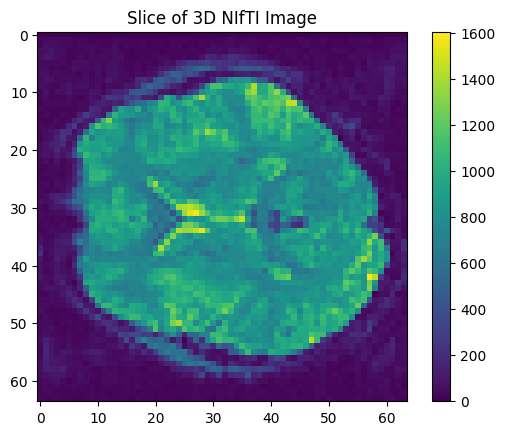

In [15]:
# Get the image data
image_data = nii_image.get_fdata()
print(image_data.shape)
# Create a 2D plot using matplotlib
plt.imshow(image_data[:, :, 25, 25])
plt.title('Slice of 3D NIfTI Image')
plt.colorbar()
plt.show()


#### open dimensional image

In [22]:
def open34D(nii_image_path, selected_volume=0):
    # Load the NIfTI image
    nii_image = nib.load(nii_image_path)

    # Get the image data as a NumPy array
    img_data = nii_image.get_fdata()
    shape = img_data.shape
    if len(shape) == 4:
        img_data = img_data[:, :, :, selected_volume]
    else: 
        img_data = img_data[:, :, 86:]


    # Check the data dimensions
    if img_data.ndim != 3:
        raise ValueError("The NIfTI image should be 3D, but it has {} dimensions.".format(img_data.ndim))

    # Check the data type (Mayavi prefers floating-point data)
    if img_data.dtype != np.float32:
        img_data = img_data.astype(np.float32)

    # Create a Mayavi volume visualization
    src = mlab.pipeline.scalar_field(img_data)
    vol = mlab.pipeline.volume(src)

    # Customize the visualization (optional)
    vol._volume_property.shade = False  # Enable shading
    vol._volume_property.diffuse = 0.7  # Adjust diffuse lighting
    vol._volume_property.specular = 0.2  # Adjust specular lighting

    # Show the visualization
    mlab.show()
    print(shape)

In [39]:
def open2D(file_path, position=50):
    # Get the image data
    nii_image = nib.load(file_path)
    image_data = nii_image.get_fdata()
    
    shape = nii_image.header.get_data_shape()
    print(shape)
    if len(shape) == 2:
        plt.imshow(image_data)
        plt.title('Slice of 3D Image')
        plt.colorbar()
        plt.show()
    elif len(shape) == 3:
        plt.imshow(image_data[:, :, position])
        plt.title('Slice of 3D Image')
        plt.colorbar()
        plt.show()
    elif len(shape) == 4:
        image_data = image_data[:, :, :, position]
        plt.imshow(image_data[:, :, image_data.shape[2]//2])
        plt.title('Slice of 3D Image')
        plt.colorbar()
        plt.show()
    else:
        print("error, shape = ", len(shape))
    print(shape)

(64, 64, 50, 213)


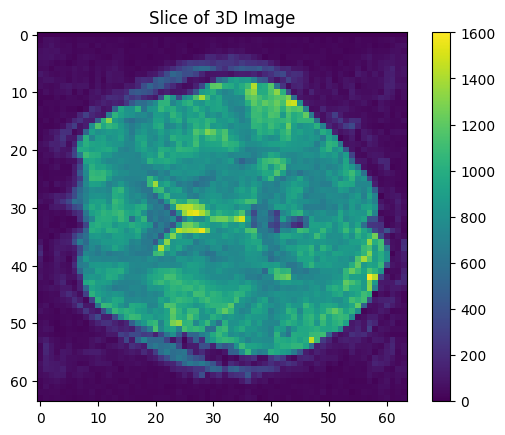

(64, 64, 50, 213)


In [40]:
open2D(path)

In [23]:
open34D(path)

(64, 64, 50, 213)


#### unzip

In [ ]:
def unzip(gzipped_file_path):
    with gzip.open(gzipped_file_path, 'rb') as f_in:
        unzipped_file_path = gzipped_file_path.replace('.gz', '')
        with open(unzipped_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    # Delete the original gzipped file
    os.remove(gzipped_file_path)
    
    return unzipped_file_path

In [ ]:
# per ogni cartella e per ogni files all'interno unzip
for root, dirs, files in os.walk("data\sub-01"):
    for file in tqdm(files, desc="Processing"):
        try:
            if file.endswith(".gz"):
                file_path = os.path.join(root, file)
                unzip(file_path)
        except gzip.BadGzipFile:
            print(f"BadGzipFile: {file}")
            continue

####

(64, 64, 50, 213)


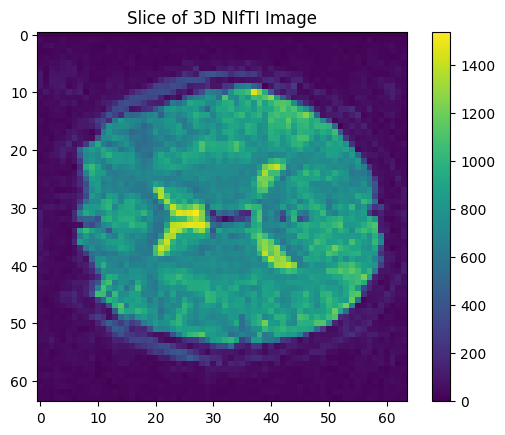

(64, 64, 50, 213)


In [20]:
file_path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-05\ses-imageryTest01\func\sub-05_ses-imageryTest01_task-imagery_run-01_bold.nii"
open2D(file_path)

# Semplification of the data

## Primo sfoltimento

In [ ]:
def sum_nii_tsv(path, x):
    c = 0
    # per ogni file all'interno della cartella path somma tutti i .nii e crea un unico file .nii
    every_nii = []
    count= 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".nii"):
                nii_image = nib.load(os.path.join(root, file))
                image_data = nii_image.get_fdata()
                print("single .nii file shape:   ", image_data.shape)
                print("upper file path", file)
                count += image_data.shape[3]
                every_nii.append(image_data)
                os.remove(os.path.join(root, file))

    every_nii = np.array(every_nii)
    desired_shape = (64, 64, 50, count)
    print("desired shape :  ", desired_shape)

    # Create an empty array to store the sum
    result = np.zeros(desired_shape, dtype=np.float32)

    # Sum the 3D images along the fourth dimension
    for i in range(len(every_nii)):
        imgs = every_nii[i]
        shape = imgs.shape[3]
        for j in range(shape):
            result[:, :, :, c] = imgs[:, :, :, j]
            c += 1

    # Now result should have the sum of all images
    print("result:   ", result.shape)

    result = result.astype(np.float32)
    np.save(fr"{path}\data{x}.npy", result)


    # sommare files .tsv
    valid_lines = []
    for root, dirs, files in os.walk(path):
        tsv_files = [file for file in files if file.endswith(".tsv")]
        tsv_files.sort()  # Ordina i file in base ai loro nomi
        for file in tsv_files:
            print("tsv file ", file)
            with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                for line in f:
                    try:
                        # Attempt to split the line into columns using tab as the separator
                        columns = line.strip().split('\t')
                        # se inizia con onset togli la riga
                        if columns[0] == "onset":
                            continue
                        else:
                            valid_lines.append(columns)
                    except Exception as e:
                        print(f"Skipping line due to error: {e}")
            os.remove(os.path.join(root, file))


    every_tsv= pd.DataFrame(valid_lines)

    # save .csv
    every_tsv.to_csv(fr"{path}\data{x}.csv", index=False, header=False)


In [ ]:
valid_lines = []
for x in range(1, 4):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest0{x}\func"

    sum_nii_tsv(path, x)
    
    with open(f'{path}\data{x}.csv', 'r', encoding='utf-8') as f:
    
        for line in f:
            try:
                # Attempt to split the line into columns using tab as the separator
                columns = line.strip().split('\t')
                valid_lines.append(columns)
            except Exception as e:
                print(f"Skipping line due to error: {e}")


every_tsv = pd.DataFrame(valid_lines)
# Save the final summed DataFrame to a new CSV file
every_tsv.to_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest.csv", index=False)



In [ ]:
valid_lines = []
for x in range(1, 5):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest0{x}\func"
    sum_nii_tsv(path, x)
    
    with open(f'{path}\data{x}.csv', 'r', encoding='utf-8') as f:
    
        for line in f:
            try:
                # Attempt to split the line into columns using tab as the separator
                columns = line.strip().split('\t')
                valid_lines.append(columns)
            except Exception as e:
                print(f"Skipping line due to error: {e}")


every_tsv = pd.DataFrame(valid_lines)
# Save the final summed DataFrame to a new CSV file
every_tsv.to_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest.csv", index=False)

In [ ]:
valid_lines = []
for x in range(1, 4):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining0{x}\func"
    sum_nii_tsv(path, x)
    
    with open(f'{path}\data{x}.csv', 'r', encoding='utf-8') as f:
    
        for line in f:
            try:
                # Attempt to split the line into columns using tab as the separator
                columns = line.strip().split('\t')
                valid_lines.append(columns)
            except Exception as e:
                print(f"Skipping line due to error: {e}")


every_tsv = pd.DataFrame(valid_lines)
# Save the final summed DataFrame to a new CSV file
every_tsv.to_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.csv", index=False)

In [ ]:
count = 0
for x in range(3):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest0{x+1}\func\data{x+1}.npy"
    data = np.load(path)
    print(data.shape)
    count += data.shape[3]
empty = np.zeros((64, 64, 50, count), dtype=np.float32)
print(empty.shape)
c = 0
for x in range(3):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest0{x+1}\func\data{x+1}.npy"
    data = np.load(path)
    for i in range(data.shape[3]):
        empty[:, :, :, c] = data[:, :, :, i]
        c += 1
np.save(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest.npy", empty)

In [ ]:
count = 0
for x in range(4):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest0{x+1}\func\data{x+1}.npy"
    data = np.load(path)
    print(data.shape)
    count += data.shape[3]
empty = np.zeros((64, 64, 50, count), dtype=np.float32)
print(empty.shape)
c = 0
for x in range(4):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest0{x+1}\func\data{x+1}.npy"
    data = np.load(path)
    for i in range(data.shape[3]):
        empty[:, :, :, c] = data[:, :, :, i]
        c += 1

np.save(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest.npy", empty)

In [ ]:
count = 0
for x in range(3):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining0{x+1}\func\data{x+1}.npy"
    data = np.load(path)
    print(data.shape)
    count += data.shape[3]
empty = np.zeros((64, 64, 50, count), dtype=np.float32)
print(empty.shape)
c = 0
for x in range(3):
    path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining0{x+1}\func\data{x+1}.npy"
    data = np.load(path)
    for i in range(data.shape[3]):
        empty[:, :, :, c] = data[:, :, :, i]
        c += 1
np.save(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.npy", empty)

In [ ]:
# onset	duration	trial_no	event_type	category_id	category_name	category_index	response_time	evaluation

header_imagery = ["onset", "duration", "trial_no", "event_type", "category_id", "category_name", "category_index", "response_time", "evaluation"]
# onset	duration	trial_no	event_type	stimulus_id	stimulus_name	category_index	image_index	response_time
header_perception = ["onset", "duration", "trial_no", "event_type", "stimulus_id", "stimulus_name", "category_index", "image_index", "response_time"]

In [ ]:
imagery = pd.read_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest.csv", header=None)
imagery = imagery.iloc[1:]
imagery.columns = header_imagery
# save
imagery.to_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest.csv", index=False, header=True)

In [ ]:
perception = pd.read_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest.csv", header=None)
# perception = perception.iloc[1:]
perception.columns = header_perception
perception.to_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTest.csv", index=False, header=True)

In [ ]:
training = pd.read_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.csv", header=None)
# training = training.iloc[1:]
training.columns = header_perception
training.to_csv(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.csv", index=False, header=True)

In [8]:
test = np.load(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-imageryTest.npy")

In [ ]:
test.shape

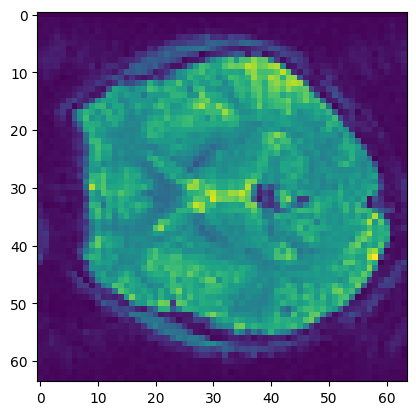

In [9]:
# print 2d image
plt.imshow(test[:, :, 25, 4259])

# allineamento immagini con scansioni

In [ ]:
# allineare immagine brain e immagine 2dtrasformali in array numpy
# formato immagine 2d: Un array 4D con le dimensioni (numero_di_campioni, altezza, larghezza, canali).
# formato immagine brain: Un array 4D con le dimensioni (numero_di_campioni, altezza, larghezza, profondità).


In [10]:
pathCSV = fr"c:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.csv"
df = pd.read_csv(pathCSV, index_col=False, sep=",")

In [11]:
df

,onset,duration,trial_no,event_type,stimulus_id,stimulus_name,category_index,image_index,response_time
0,0,33,1,rest,NaN,NaN,NaN,NaN,NaN
1,33,9,2,stimulus,2.766534e+06,n02766534_15976,41.0,324.0,NaN
2,42,9,3,stimulus,1.970164e+06,n01970164_28566,17.0,134.0,NaN
3,51,9,4,stimulus,4.376876e+06,n04376876_11868,127.0,1011.0,NaN
4,60,9,5,stimulus,4.225987e+06,n04225987_6665,117.0,934.0,NaN
...,...,...,...,...,...,...,...,...,...
1363,492,9,53,stimulus,2.054036e+06,n02054036_5709,19.0,150.0,NaN
1364,501,9,54,stimulus,1.639765e+06,n01639765_47681,2.0,14.0,NaN
1365,510,9,55,stimulus,3.397947e+06,n03397947_7453,68.0,542.0,NaN
1366,519,9,56,stimulus,2.508213e+06,n02508213_10059,39.0,305.0,NaN


In [24]:
images = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\images\test"

In [23]:
def ImageBrain(brains, df, x):
    durata = 0
    brain = brains[:, :, :, x]  
    x = x*3
    for index in range(df.shape[0]):
        try:
            duration = df["duration"][index]
            duration = int(duration)
            durata += duration
            if durata > x:
                stimolo = df["stimulus_name"][index]
                break
        except:
            print("error")
            continue
    for root, dirs, files in os.walk(images):
        for file in files:
            if file.startswith(stimolo):
                print("file: ", file)
                # return a numpy image
                image_np = plt.imread(os.path.join(root, file))
                image_np = cv2.resize(image_np, (64, 64))
                break
    return image_np, brain

In [27]:
def preproFinale(pathBrain, pathCSV):
    test = np.load(pathBrain)
    print(test.shape)
    brains_vari = np.zeros((64, 64, 50, test.shape[3]), dtype=np.float32)
    features_vari = np.zeros((64, 64, 3, test.shape[3]), dtype=np.float32)
    #64*64*50*batch_size
    c = 0
    df = pd.read_csv(pathCSV, index_col=False, sep=",")

    for x in range(test.shape[3]):
        try:
            print(test.shape[3])
            feature, brain = ImageBrain(test, df, x)
            print(feature.shape)
            brains_vari[:, :, :, x] = brain
            features_vari[:, :, :, x] = feature
            c = c+1
        except:
            print("typeError")
            continue

    print(c)

    return brains_vari, features_vari

In [29]:
brains_path = fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.npy"
csv_path = fr"c:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.csv"
brains_vari, features_vari = preproFinale(brains_path, csv_path)

(4272, 64, 64, 50)
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
typeError
50
file:  n02766534_15976.JPEG
(64, 64, 3)
typeError
50
file:  n02766534_15976.JPEG
(64, 64, 3)
typeError
50
file:  n02766534_15976.JPEG
(64, 64, 3)
typeError
50
file:  n01970164_28566.JPEG
(64, 64, 3)
typeError
50
file:  n01970164_28566.JPEG
(64, 64, 3)
typeError
50
file:  n01970164_28566.JPEG
(64, 64, 3)
typeError
50
file:  n04376876_11868.JPEG
(64, 64, 3)
typeError
50
file:  n04376876_11868.JPEG
(64, 64, 3)
typeError
50
file:  n04376876_11868.JPEG
(64, 64, 3)
typeError
50
file:  n04225987_6665.JPEG
(64, 64, 3)
typeError
50
file:  n04225987_6665.JPEG
(64, 64, 3)
typeError
50
file:  n04225987_6665.JPEG
(64, 64, 3)
typeError
50
file:  n03079230_8270.JPEG
(64, 64, 3)
typeError
50
file:  n03079230_8270.JPEG
(64, 64, 3)
typeError
50
file:  n03079230_8270.JPEG
(64, 64, 3)
typeError
50
file:  n03079230_8270.JPEG
(64, 64, 3)
typeErr

In [80]:
brains_vari = np.transpose(brains_vari, (3, 0, 1, 2))
brains_vari.shape

(4272, 64, 64, 50)

In [81]:
features_vari = np.transpose(features_vari, (3, 0, 1, 2))
features_vari.shape

(4272, 64, 64, 3)

In [82]:
# Normalize the data (you can use any appropriate scaling method)
brains_vari = brains_vari / 255.0
features_vari = features_vari / 255.0

In [83]:
np.save(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTrainingImages.npy", features_vari)
np.save(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.npy", brains_vari)

# Training

In [13]:
# imput
from tensorflow.keras.layers import Input
# layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError, CosineSimilarity, LogCoshError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

In [14]:
images = np.load(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTrainingImages.npy")

In [15]:
brain_scans = np.load(fr"C:\Users\StefanoCarobene\Desktop\appunti\DeepLearning_Project\data\sub-01\ses-perceptionTraining.npy")

## Prima prova

In [49]:

# Define the encoder-decoder architecture
input_img = Input(shape=(64, 64, 50))  # Input shape for brain scans
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)


encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the encoded representation is (8, 8, 128)

# Decoder
x = Conv2D(1024, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output has 3 channels for RGB images
# attivazione potrebbe ess. da cambiare


# Define the callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'auto', patience=5, min_lr=0.0001, verbose=1)
    LearningRateScheduler(lambda epoch: 1e-3 * tf.math.exp(-0.1*(epoch//10)))
]


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=MeanAbsoluteError(), metrics=RootMeanSquaredError())  # You can use other loss functions depending on your data and goals


# Train the autoencoder
autoencoder.fit(brain_scans, 
                images, 
                epochs=50, 
                batch_size=64, 
                shuffle=True, 
                validation_split=0.2,
                steps_per_epoch=107,
                initial_epoch=0,
                callbacks=callbacks
                )


model_path = fr"autoencoder.keras"
# Save the model
autoencoder.save_weights(model_path)

Epoch 1/50
  7/107 [>.............................] - ETA: 36:26 - loss: 0.2967 - root_mean_squared_error: 0.3499

KeyboardInterrupt: 

In [ ]:
model_path = fr"autoencoder.keras"
# Save the model
autoencoder.load_weights(model_path)



brain_train = brain_scans[100, :, :, :]
image_train = images[100, :, :, :]
single_brain_scan = np.expand_dims(brain_train, axis=0)
reconstructed_train = autoencoder.predict(single_brain_scan)

image_train= image_train[:, :, :]

image_train = ( image_train * 255).astype(np.uint8)

reconstructed_image = reconstructed_train[0, :, :, :]

reconstructed_image = (reconstructed_image * 255).astype(np.uint8)

print(image_train.shape)

print(reconstructed_image.shape)


Image.fromarray(image_train, mode="RGB").save("img.png")

Image.fromarray(reconstructed_image, mode="RGB").save("img2.png")


## Seconda prova 

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError, CosineSimilarity, LogCoshError
import matplotlib.pyplot as plt

# load preprocessed data
images = np.load(fr"ses-perceptionTrainingImages.npy")
brain_scans = np.load(fr"ses-perceptionTraining-001.npy")

# encoder-decoder architecture with residual connections and batch normalization
def build_autoencoder_with_residual():
    input_img = Input(shape=(64, 64, 50))
    
    # encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D((2, 2), padding='same')(x)
    residual_1 = x  # residual connection
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D((2, 2), padding='same')(x)
    residual_2 = x  # residual connection
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # decoder
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # x = tf.keras.layers.Add()([x, residual_2])
    x += residual_2
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    # x = tf.keras.layers.Add()([x, residual_1])
    x += residual_1
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder


autoencoder_with_residual = build_autoencoder_with_residual()
autoencoder_with_residual.compile(optimizer='sgd', loss='mean_squared_error', metrics=RootMeanSquaredError())

# callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'auto', patience=5, min_lr=0.0001, verbose=1),
    LearningRateScheduler(lambda epoch: 1e-3 * tf.math.exp(-0.1*(epoch//10)))
]

# training
autoencoder_with_residual.fit(brain_scans, images, 
                              epochs=50, batch_size=32, 
                              shuffle=True,
                              validation_split=0.2)

model_path = fr"autoencoder.keras"
# Save the model
autoencoder_with_residual.save_weights(model_path)

# loss history
awr = autoencoder_with_residual
plt.plot(awr.history['loss'])
plt.plot(awr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 25s 25s/step - loss: 0.2004 - root_mean_squared_error: 0.4476 - val_loss: 0.1834 - val_root_mean_squared_error: 0.4282


In [20]:
model_path = fr"c:\Users\StefanoCarobene\Downloads\autoencoder.keras"
# Save the model
autoencoder_with_residual.load_weights(model_path)



brain_train = brain_scans[1000, :, :, :]
image_train = images[1000, :, :, :]
single_brain_scan = np.expand_dims(brain_train, axis=0)
reconstructed_train = autoencoder_with_residual.predict(single_brain_scan)

image_train= image_train[:, :, :]

image_train = ( image_train * 255).astype(np.uint8)

reconstructed_image = reconstructed_train[0, :, :, :]

reconstructed_image = (reconstructed_image * 255).astype(np.uint8)

print(image_train.shape)

print(reconstructed_image.shape)


Image.fromarray(image_train, mode="RGB").save("img.png")

Image.fromarray(reconstructed_image, mode="RGB").save("img2.png")


ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.